In [1]:
import numpy as np
from scipy.fft import fft, ifft, rfft, irfft, fftfreq
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from matplotlib import rcParams
import matplotlib.animation as animation
import time
import scipy.integrate as integrate
from scipy.integrate import solve_ivp


import sys
sys.path.append('..')
import QLCstuff as QLC
import QLC_FT as QLC_FT
import f90nml
import importlib
importlib.reload(QLC_FT)

<module 'QLC_FT' from 'c:\\Users\\spenc\\Desktop\\2024 research\\icecontinuum\\2024 - Spencer\\QLC_FT.py'>

In [2]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

In [3]:
inputfile = "GI parameters - Reference limit cycle copy.nml"

In [4]:
# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle copy.nml ...

From the GrowthInstability (GI) namelist:
D = 0.000365 micrometer ** 2 / microsecond
L = 30 micrometer
nx (crystal) = 100
odemethod = RK45


In [5]:
# Conversions (in case inputs are in other units)
D.ito('micrometer^2/microsecond')
L.ito('micrometer')

In [6]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
DoverdeltaX2 = D/deltax**2
print(deltax ** 2)

Spacing of points on the ice surface = 0.6060606060606055 micrometer
0.3673094582185485 micrometer ** 2


In [7]:
def diffusion_term_cart(NQLL0, DoverdeltaX2):
    dy = np.empty(np.shape(NQLL0))
    for i in range(1,len(NQLL0)-1):
        dy[i] = DoverdeltaX2*(NQLL0[i-1]-2*NQLL0[i]+NQLL0[i+1])
    dy[0]  = DoverdeltaX2*(NQLL0[-1] -2*NQLL0[0] +NQLL0[1]) # Periodic BC
    dy[-1] = DoverdeltaX2*(NQLL0[-2] -2*NQLL0[-1]+NQLL0[0])
    
    return dy

C:\Users\spenc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


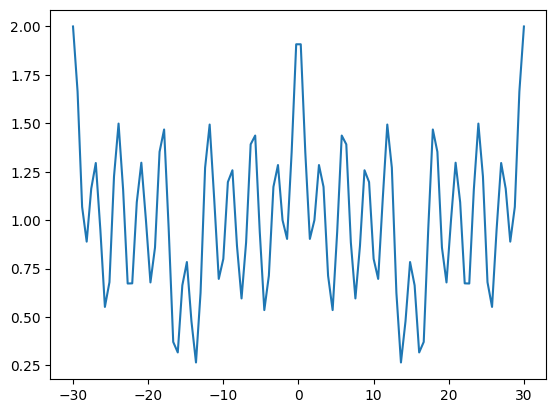

In [8]:
NQLL0 = ((1/5) * np.cos(x_QLC * 2 * np.pi / L) + 
         (1/5) * np.cos(x_QLC * 6 * np.pi / L) + 
         (1/5) * np.cos(x_QLC * 10 * np.pi / L) + 
         (1/5) * np.cos(x_QLC * 20 * np.pi / L) + 
         (1/5) * np.cos(x_QLC * 20 * np.pi / L) + 
         1)
plt.figure()
plt.plot(x_QLC.magnitude, NQLL0)

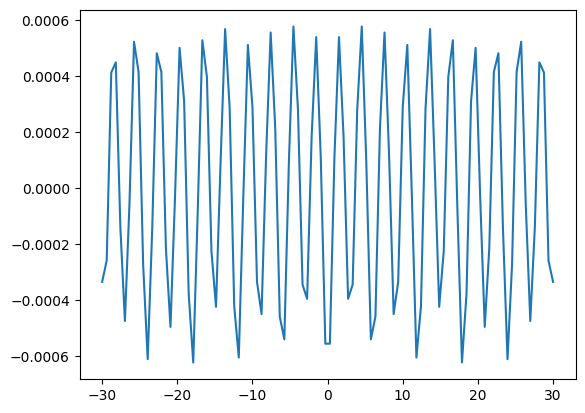

In [9]:
test = diffusion_term_cart(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test)

In [10]:
#test diffusion term function

"""
test_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)
plt.figure()
plt.plot(x_QLC.magnitude, test_analytical)
"""

'\ntest_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)\nplt.figure()\nplt.plot(x_QLC.magnitude, test_analytical)\n'

In [11]:
dt = deltax ** 2 / D / 20
print(dt)
t_max = AssignQuantity(500, 'milliseconds')
n_t = int(t_max / dt)
print(n_t)

50.316364139527195 microsecond
9937


In [12]:

tic = time.perf_counter()
NQLL = np.copy(NQLL0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_cart(NQLL, DoverdeltaX2.magnitude)
    NQLL += term_1
toc = time.perf_counter()
print(f"Code took {toc - tic:0.4f} seconds")


Code took 117.1025 seconds


Text(0.5, 1.0, 'Final NQLL using Cartesian coordinates')

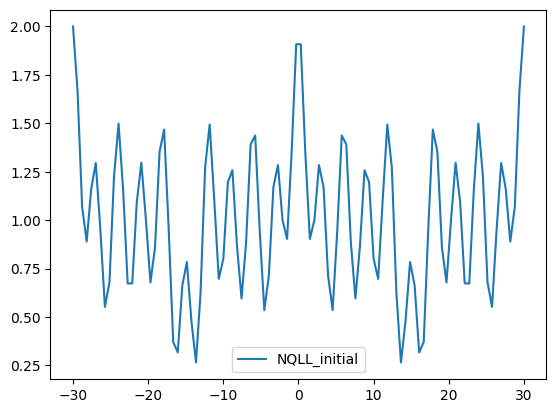

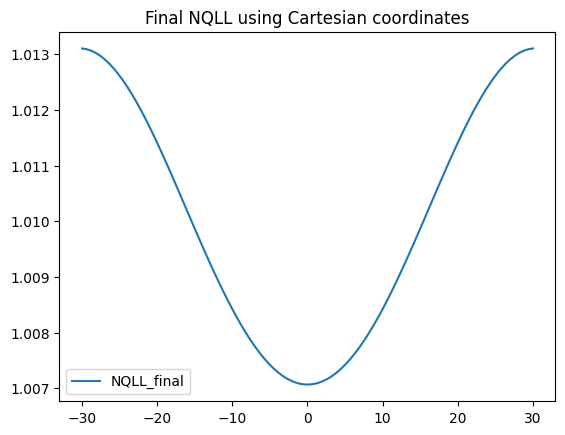

In [13]:
plt.figure()
plt.plot(x_QLC.magnitude, NQLL0, label = "NQLL_initial")
plt.legend()

plt.figure()
plt.plot(x_QLC.magnitude, NQLL, label = 'NQLL_final')
plt.legend()
plt.title('Final NQLL using Cartesian coordinates')

In [14]:
bj_list0 = rfft(NQLL0)
j_list = np.array([j for j in range(len(bj_list0))])
j2_list = np.array(j_list)**2
print(j_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


C:\Users\spenc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\fft\_pocketfft\helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


In [15]:
# Diffusion term based on FT
def diffusion_term_FT(NQLL0, DoverdeltaX2):
    l = int(len(NQLL0)/2)
    Dcoefficient1 = DoverdeltaX2/l**2*np.pi**2; #print('Dcoefficient1', Dcoefficient1)
    bj_list = rfft(NQLL0)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1  * irfft(cj_list)

    return dy

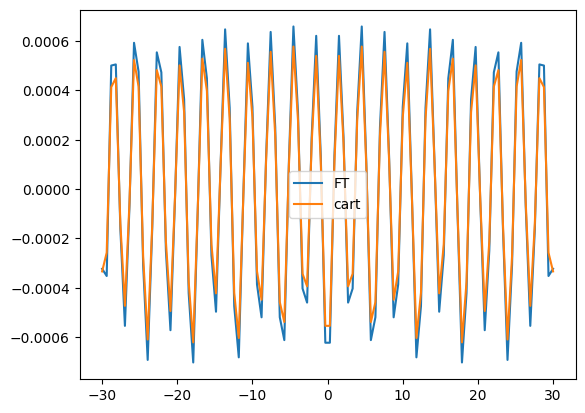

In [16]:
test_FT = diffusion_term_FT(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test_FT, label = 'FT')
plt.plot(x_QLC.magnitude, test, label = 'cart')
plt.legend()

In [17]:
def diffusion_term_FT_b_list(bj_list, D, L):
    Dcoefficient1 = D*np.pi**2/(L**2); #print('Dcoefficient1', Dcoefficient1)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1 * cj_list
    return dy

In [18]:
# Solving in the Fourier domain (i.e., for b_j(t))
tic = time.perf_counter()
bj_list = np.copy(bj_list0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_FT_b_list(bj_list, D.magnitude, L.magnitude)
    bj_list += term_1
toc = time.perf_counter()
print(f"Code took {toc - tic:0.4f} seconds")

Code took 0.1627 seconds


Text(0.5, 1.0, 'Initial and final NQLL using Euler integration, with Fourier coordinates')

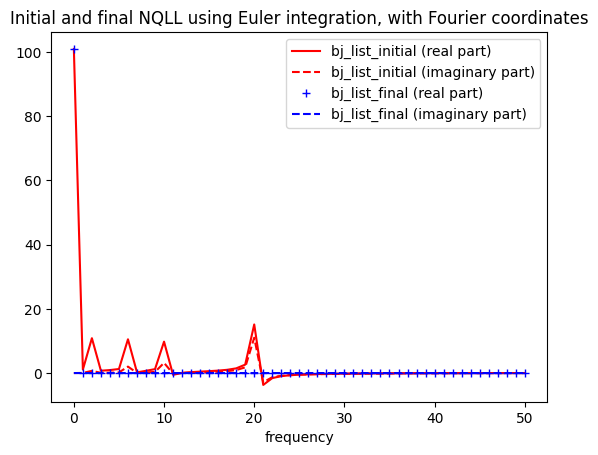

In [19]:
# Graphing the results in the Fourier domain
j_list = np.array([j for j in range(len(bj_list))])
plt.figure()
plt.plot(j_list, np.real(bj_list0), 'r', label = 'bj_list_initial (real part)')
plt.plot(j_list, np.imag(bj_list0), 'r--', label = 'bj_list_initial (imaginary part)')
plt.plot(j_list, np.real(bj_list), 'b+', label = "bj_list_final (real part)")
plt.plot(j_list, np.imag(bj_list), 'b--', label = "bj_list_final (imaginary part)")
plt.legend()
plt.xlabel('frequency')
plt.title('Initial and final NQLL using Euler integration, with Fourier coordinates')

Text(0.5, 1.0, 'Final NQLL using k-space variables "b"')

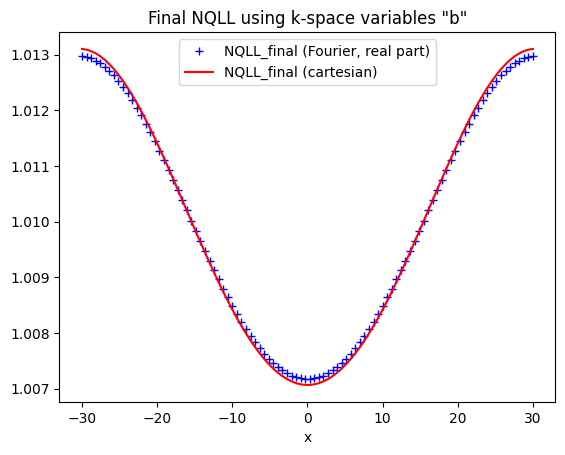

In [20]:
NQLL_FTsolution0 = irfft(bj_list0)
NQLL_FTsolution = irfft(bj_list)
plt.figure()
plt.plot(x_QLC.magnitude,np.real(NQLL_FTsolution), 'b+', label = 'NQLL_final (Fourier, real part)')
plt.plot(x_QLC.magnitude, NQLL, 'r', label = 'NQLL_final (cartesian)')
plt.legend()
plt.xlabel('x')
plt.title('Final NQLL using k-space variables "b"')

In [21]:
def diffusion_term_FT_b_list_integrator(t, bj_list, j2_list, scalar_params):
    D, L = scalar_params

    Dcoefficient1 = D*np.pi**2/(L**2); #print('Dcoefficient1', Dcoefficient1)
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1 * cj_list
    return dy

In [22]:

scalar_params = [D.magnitude, L.magnitude]
j_list = np.array([j for j in range(len(bj_list))])
j2_list = np.array(j_list)**2
bj_list0 = rfft(NQLL0.magnitude)
tinterval = [0, 500000]

tic = time.perf_counter()

sol = solve_ivp(QLC_FT.diffusion_term_FT_b_list_integrator, tinterval, bj_list0, args = (j2_list, scalar_params))

toc = time.perf_counter()
print(f"Code took {toc - tic:0.4f} seconds")

Code took 0.3165 seconds


In [23]:
NQLL_final = irfft(sol.y[:,-1])
print(NQLL_final)

[1.01297228 1.01295967 1.01293459 1.01289706 1.01284736 1.01278566
 1.01271234 1.01262769 1.01253221 1.01242628 1.0123105  1.01218534
 1.0120515  1.01190951 1.01176015 1.011604   1.01144189 1.01127445
 1.01110253 1.01092681 1.01074813 1.01056718 1.01038481 1.0102017
 1.01001868 1.0098364  1.00965566 1.00947708 1.00930143 1.00912927
 1.00896131 1.00879806 1.0086402  1.00848816 1.00834254 1.00820374
 1.00807229 1.0079485  1.00783286 1.00772561 1.00762718 1.00753775
 1.00745766 1.00738706 1.00732623 1.00727525 1.00723434 1.00720352
 1.00718296 1.00717264 1.00717266 1.00718294 1.00720354 1.00723431
 1.00727527 1.00732621 1.00738708 1.00745764 1.00753777 1.00762716
 1.00772564 1.00783283 1.00794852 1.00807226 1.00820376 1.00834252
 1.00848818 1.00864018 1.00879809 1.00896128 1.00912929 1.00930141
 1.00947711 1.00965564 1.00983642 1.01001866 1.01020172 1.01038479
 1.0105672  1.01074811 1.01092683 1.01110251 1.01127447 1.01144186
 1.01160402 1.01176012 1.01190954 1.01205148 1.01218537 1.01231

Text(0.5, 1.0, 'Final NQLL after integrating with RK45')

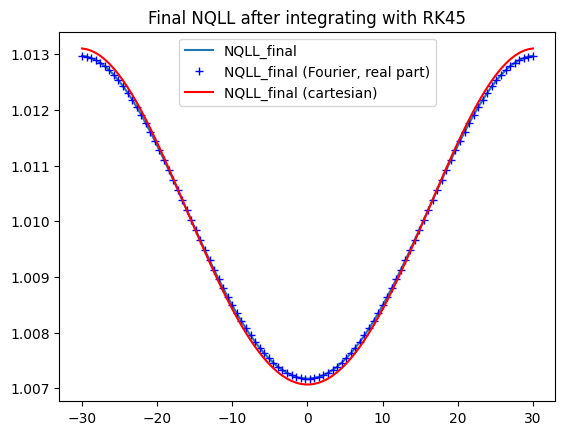

In [24]:
plt.figure()
plt.plot(x_QLC.magnitude, NQLL_final, label = 'NQLL_final')
plt.plot(x_QLC.magnitude,np.real(NQLL_FTsolution), 'b+', label = 'NQLL_final (Fourier, real part)')
plt.plot(x_QLC.magnitude, NQLL, 'r', label = 'NQLL_final (cartesian)')
plt.legend()
plt.title('Final NQLL after integrating with RK45')